In [1]:
#essential imports
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize

#scraping imports
import requests
from bs4 import BeautifulSoup

#plotting imports
%matplotlib inline
import matplotlib.pyplot as plt

#String matching
import re

# Date
import datetime as dt
# Sleep
import time

# Strict JSON conversion
import json 
import gzip 

# Progress display
from IPython.display import clear_output

# Amazon API querying
from amazon.api import AmazonAPI
from amazon.api import AsinNotFound

#garbage collector
import gc

cps = 4
datapath = 'DATA/review_filtered/'
f_subjects = datapath+'music_reviews_matched_'+str(cps)+'cps.csv'
f_controls = datapath+'music_reviews_matched_'+str(cps)+'cps_ctrls.csv'

# Load data

In [2]:
subjects_actors = pd.read_csv(f_subjects).drop('Unnamed: 0',axis=1)
subjects_actors = subjects_actors.rename(columns={'reviewTime' : 'strReviewTime', 'name' : 'actor name'})
subjects_actors.head(3)

,asin,reviewText,summary,strReviewTime,actor name,death date,birth date
0,B000KB9Y6U,I bought this item because it did not say vyna...,Should be more descriptive in the title.,2013-05-23,paul delph,1996-05-21,1957
1,B000KB9Y6U,Chrissy Faith is wonderful I must say!! What ...,You should listen this!!,2013-11-09,paul delph,1996-05-21,1957
2,B000KB9Y6U,this product came quickly and there were no is...,great music,2013-04-26,paul delph,1996-05-21,1957


In [3]:
controls_actors = pd.read_csv(f_controls).drop('Unnamed: 0',axis=1)
controls_actors = controls_actors.rename(columns={'reviewTime' : 'strReviewTime', 'name' : 'actor name'})
controls_actors.head(3)

,asin,reviewText,summary,strReviewTime,actor name,death date,birth date
0,B0002VYEHW,"In a reggae universe gone mad for dancehall, T...",Plain good reggae,2005-08-23,tike jah fakoly,unknown,unknown
1,B0002VYEHW,"Tiken Jah's ""Coup de Gueule"" is on the continu...","MBafoh Pian!!!( I Shall Say It Loud and Sound,...",2006-03-10,tike jah fakoly,unknown,unknown
2,B0040AT66U,This is very touching little opera. The libret...,A Mini Masterpiece,2013-05-28,patricia risley,unknown,unknown


# Convert dates to timestamps / years

Convert dates to year and extract and set aside actor<-> deathdates

In [4]:
#counts = subjects_actors.groupby('actor name').count()
#subjects_actors['death date'] = pd.to_datetime('2001').year

''' Takes a serie !
'''
def strdateToYear(date) : 
    return int(date[:4])

# SUBJECTS
subjects_actors['reviewYear'] = subjects_actors['strReviewTime'].apply(strdateToYear)
subjects_actors['reviewTime'] = pd.to_datetime(subjects_actors['strReviewTime'])
subjects_actors['death year'] = subjects_actors['death date'].apply(strdateToYear)
subjects_actors['death date'] = pd.to_datetime(subjects_actors['death date'])

# CONTROLS
controls_actors['reviewYear'] = controls_actors['strReviewTime'].apply(strdateToYear)
controls_actors['reviewTime'] = pd.to_datetime(controls_actors['strReviewTime'])

Extract death dates and subjects names

In [5]:
deathdates = subjects_actors.groupby(['actor name','death date', 'death year']).count()\
                            .reset_index()[['actor name', 'death date', 'death year']]
sbj_names = list(deathdates['actor name'])
deathdates.head()

,actor name,death date,death year
0,adrian borland,1999-04-26,1999
1,akira ifukube,2006-02-08,2006
2,al hirt,1999-04-27,1999
3,al martino,2009-10-13,2009
4,alain bashung,2009-03-14,2009


Extract controls names

In [6]:
ctrl_names = list(set(controls_actors['actor name']))

# Pre-filtering

### Filtering on populatiry

Filter actors based on their popularity: they should be mentioned at least once in the reviews. It is a way to be sure the reviewers know the actor.

In [7]:
thresh_pop = 1

def mentionsName(row) : 
    if type(row['reviewText']) is str :
        names = row['actor name'].split(' ')
        text =  row['reviewText'].lower()
        # can mention only name or surname
        #return row['actor name'] in row['reviewText']
        for name in names : 
            if name in text : 
                return True
        return False
    else : return False

In [8]:
subjects_actors['mentionned'] = subjects_actors.apply(mentionsName, axis=1)
subjects_actors.shape, subjects_actors[subjects_actors['mentionned']==True].shape

((320780, 11), (96181, 11))

In [9]:
## Not necessarily needed, count of mentions are still in the reviews dataframe
##
sbj_popular = subjects_actors[subjects_actors['mentionned']==True]
sbj_popular = sbj_popular.groupby('actor name').count()['asin']
print(len(sbj_names), " reduced to", sbj_popular.shape)
sbj_popular.sort_values(ascending=False)[:10]

368  reduced to (348,)


actor name
the rev            9136
johnny cash        4492
big l              2960
whitney houston    2392
john denver        2139
lou reed           2066
ella fitzgerald    1706
ray charles        1642
george jones       1585
donna summer       1535
Name: asin, dtype: int64

In [10]:
controls_actors['mentionned'] = controls_actors.apply(mentionsName, axis=1)
controls_actors.shape, controls_actors[controls_actors['mentionned']==True].shape

((119120, 10), (38852, 10))

In [11]:
## Not necessarily needed, count of mentions are still in the reviews dataframe
##
ctl_popular = controls_actors[controls_actors['mentionned']==True]
ctl_popular = ctl_popular.groupby('actor name').count()['asin']
print(len(ctrl_names), " reduced to", ctl_popular.shape)
ctl_popular.sort_values(ascending=False)[:10]

1640  reduced to (1258,)


actor name
elvis presley        6307
andrea bocelli       2499
george harrison      2337
diana ross           1614
toni braxton         1125
loreena mckennitt    1028
steve winwood         806
scott weiland         766
tim buckley           677
rory gallagher        617
Name: asin, dtype: int64

### Filtering on date (2004-2013)

In [12]:
start = 1996
end = 2014

print('original size : ', subjects_actors.shape)
subjects_inTime = subjects_actors[    (subjects_actors['death year']>=start) \
                                    & (subjects_actors['death year']<=end)]
print('filtered size : ', subjects_inTime.shape)
subjects_inTime.head(3)

original size :  (320780, 11)
filtered size :  (320780, 11)


,asin,reviewText,summary,strReviewTime,actor name,death date,birth date,reviewYear,reviewTime,death year,mentionned
0,B000KB9Y6U,I bought this item because it did not say vyna...,Should be more descriptive in the title.,2013-05-23,paul delph,1996-05-21,1957,2013,2013-05-23,1996,False
1,B000KB9Y6U,Chrissy Faith is wonderful I must say!! What ...,You should listen this!!,2013-11-09,paul delph,1996-05-21,1957,2013,2013-11-09,1996,False
2,B000KB9Y6U,this product came quickly and there were no is...,great music,2013-04-26,paul delph,1996-05-21,1957,2013,2013-04-26,1996,False


# Get matching features

Extract features for subjects

In [27]:
# SUBJECTS COUNTS BY YEAR
subjects_revs = subjects_actors.groupby(['actor name','reviewYear']).count()


def getreview(actor, year) : 
    try : 
        val = subjects_revs.loc[actor, year]['asin']
        return val
    except TypeError :
        return 0
    

# FILTER TO GET THE DEATH YEAR COUNT - 1
subjects_feats = deathdates[1:].apply(lambda row : getreview(row['actor name'], int(row['death year'])-1), axis=1)
subjects_feats = pd.DataFrame(subjects_feats, columns=['reviews'])
subjects_feats['actor name'] = deathdates['actor name']
subjects_feats['death year'] = deathdates['death year']
subjects_feats['death date'] = deathdates['death date']

subjects_feats.sort_values(by='reviews', ascending=False).head()

,reviews,actor name,death year,death date
290,2109,proof,2006,2006-04-11
160,1002,james brown,2006,2006-12-25
219,577,lorin maazel,2014,2014-07-13
335,477,the rev,2009,2009-12-28
230,429,luther vandross,2005,2005-07-01


Extract features for subjects

In [14]:
controls_revs = controls_actors.groupby(['actor name','reviewYear'])\
                                .count()['asin']\
                                .to_frame().reset_index()

In [15]:
controls_revs.sort_values(by=['actor name', 'asin'], ascending=False).head()

,actor name,reviewYear,asin
7801,ã?ico membiela,2012,2
7797,ã?ico membiela,2003,1
7798,ã?ico membiela,2007,1
7799,ã?ico membiela,2010,1
7800,ã?ico membiela,2011,1


# Matching

Construct a matching function per subject

In [16]:
def match(actorname, threshold, ctrl_revs) : 

    # extract the useful features for the subject 
    sbj_actor = subjects_feats[subjects_feats['actor name'] == actorname]
    deathyear = int(sbj_actor['death year'])
    sbj_revs = int(sbj_actor['reviews'])
    
    #find the non zero reviews count for the year preceding the death of the subject
    mapp = (ctrl_revs['reviewYear']==(deathyear-1))
    
    
    if (sbj_revs == 0) and (not ctrl_revs[mapp==False].empty):
        
        # zero count subjects are matched with zero count controls 
        matched_name = ctrl_revs[mapp==False].reset_index()['actor name'].get_value(0)
        matched_count = 0
        
        # delete the matched control 
        ctrl_revs = ctrl_revs[ctrl_revs['actor name'].isin([matched_name])==False]
        
        return matched_name, matched_count, ctrl_revs
    
    
    if mapp.any():
        
        for row in ctrl_revs[mapp].iterrows():
            #print(np.abs(sbj_revs-row[1]['asin']))
                   
            if np.abs(sbj_revs-row[1]['asin']) < threshold :
                
                matched_name = row[1]['actor name']
                matched_count = row[1]['asin']
                
                # delete the matched control
                ctrl_revs = ctrl_revs[ctrl_revs['actor name'].isin([matched_name])==False]
                
                return matched_name, matched_count, ctrl_revs
    else:
        
        matched_name = ctrl_revs.reset_index()['actor name'].get_value(0)
        matched_count = 0
        
        #delete the matched control
        ctrl_revs = ctrl_revs[ctrl_revs['actor name'].isin([matched_name])==False]
        
        return matched_name, matched_count, ctrl_revs
    
    
    return 0, 0, ctrl_revs  


In [17]:
ctrl_revs = controls_revs.copy()

print(len(ctrl_names), len(sbj_names))

1640 368


In [28]:
thresh = 5
ctrl_revs = controls_revs.copy()
sorted_subjects = subjects_feats.sort_values(by='reviews', ascending=False)
ctrl_list = [] # stores the name of matched controls
count_list = [] # stores the features of matched controls
matchings = []

for idx, subject_name in enumerate(sorted_subjects['actor name']):
    
    if idx%50 == 0: 
        print(idx, "out of ", len(subjects_feats['actor name']))
    
    mtch = 0
    thr = thresh

    while mtch == 0:
        
        thr += int(0.25*thr)
        
        if thr > 50 and thr < 70  : 
            print(subject_name+' reached threshold ', thr)
        if thr > 1000 and thr < 1499  : 
            print(subject_name+' reached threshold ', thr)
        if thr > 10000 : 
            print(subject_name+' reached threshold > 10000 (won\'t match)')
        
        name, count, ctrl_revs_ = match(subject_name,thr,ctrl_revs)
        ctrl_revs = ctrl_revs_.sample(frac=1) 
        
        
        if name != 0:
            #rint(subject_name+' matched with '+name)
            
            ctrl_list.append(name)
            count_list.append(count)
            matchings.append((subject_name, name))
            mtch += 1

0 out of  367
proof reached threshold  51
proof reached threshold  63
proof reached threshold  1113
proof reached threshold  1391
james brown reached threshold  51
james brown reached threshold  63
lou reed reached threshold  51
lou reed reached threshold  63
johnny cash reached threshold  51
etta james reached threshold  51
etta james reached threshold  63
billy preston reached threshold  51
billy preston reached threshold  63
laura branigan reached threshold  51
laura branigan reached threshold  63
layne staley reached threshold  51
layne staley reached threshold  63
john lee hooker reached threshold  51
john lee hooker reached threshold  63
syd barrett reached threshold  51
syd barrett reached threshold  63
donna summer reached threshold  51
donna summer reached threshold  63
ronnie james dio reached threshold  51
oliver reached threshold  51
oliver reached threshold  63
ray charles reached threshold  51
ray charles reached threshold  63
bo diddley reached threshold  51
bo diddley r

# Results

In [29]:
ctrl_features = pd.DataFrame(ctrl_list, columns=['ctrl_name'])
ctrl_features['ctrl_reviews'] = count_list

res = pd.concat([ctrl_features.reset_index(), sorted_subjects.reset_index()], axis=1)\
            .drop('index', axis=1)
res['error'] = np.abs(res['ctrl_reviews'] - res['reviews'])/(2*(1+res['ctrl_reviews'] + res['reviews']))

res.sort_values(by='error', ascending=False).head()

,ctrl_name,ctrl_reviews,reviews,actor name,death year,death date,error
155,harvey watkins jr,1,6,long john baldry,2005,2005-07-21,0.312500
127,frances ruffelle,3,14,curtis mayfield,1999,1999-12-26,0.305556
164,chris edwards,1,5,john phillips,2001,2001-03-18,0.285714
225,michael torke,5,1,bebo valdés,2013,2013-03-22,0.285714
218,dave hamilton,5,1,wojciech kilar,2013,2013-12-29,0.285714


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14c94cd710>]], dtype=object)

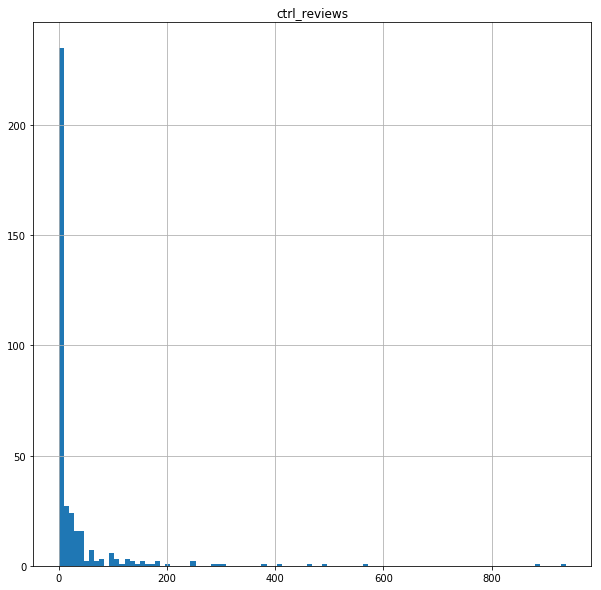

In [30]:
ctrl_features.hist(column='ctrl_reviews', figsize=[10,10], bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14c91f8908>]], dtype=object)

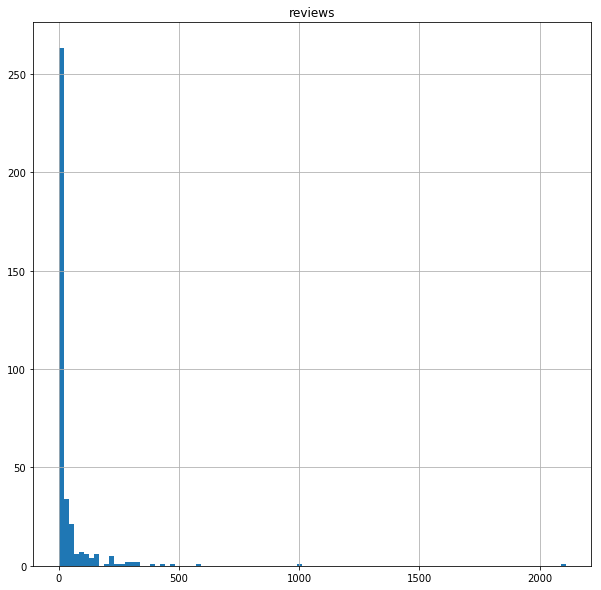

In [31]:
subjects_feats.hist(column='reviews', figsize=[10,10], bins=100)

# Export results

In [32]:
subjectsnb = str(len(sbj_names)-1)

In [33]:
subjects_actors.to_csv('DATA/reviews_cs_matched/music_reviews_subjects_'+subjectsnb+'.csv', index=False)

In [34]:
controls_actors.to_csv('DATA/reviews_cs_matched/music_reviews_controls_'+subjectsnb+'.csv', index=False)

In [35]:
res.to_csv('DATA/reviews_cs_matched/music_matchings_'+subjectsnb+'_feature=yearbefore.csv', index=False)